In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [2]:
import glob

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from sklearn.metrics import f1_score
from src.metrics import *

(512, 512, 134)
tensor([1.])


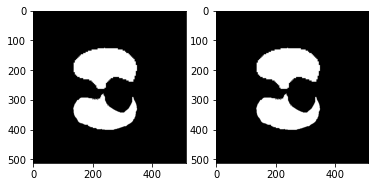

In [3]:
# test on individual masks
mask_path = glob.glob("data/raw/Thoracic_Cavities/LUNG1-001/*.nii.gz")[0]
mask_file = nib.load(mask_path)
mask_arr = np.array(mask_file.dataobj, dtype=np.int64)
mask_arr[mask_arr > 0] = 1
print(mask_arr.shape)

mask1 = torch.from_numpy(mask_arr[..., 60])
mask2 = torch.from_numpy(mask_arr[..., 60])

print(dice_coeff(mask1.unsqueeze(0), mask2.unsqueeze(0)))
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(mask1, cmap="gray")
axes[1].imshow(mask2, cmap="gray")

In [4]:
# test on batch
masks_1 = torch.from_numpy(mask_arr).permute(2, 0, 1)
# randomly shuffle slices
masks_2 = masks_1[torch.randperm(masks_1.shape[0])]

In [5]:
dice_coeff_vectorized(masks_1, masks_2)

tensor(0.3470)

In [7]:
dices = []
for i in range(0, masks_1.shape[0], 2):
    dices.append(dice_coeff_vectorized(masks_1[i:i+2], masks_2[i:i+2]).item())
np.mean(dices)

0.34698199494658927

In [6]:
f1_score(masks_1.flatten().numpy(), masks_2.flatten().numpy(), average='binary')

0.3609874134463238

In [8]:
dice_coeff_vectorized(masks_1.reshape(1, -1), masks_2.reshape(1,-1))

tensor(0.3610)

In [33]:
torch.abs(masks_1 - masks_2).sum()

tensor(2466590)

In [39]:
d0 = dice_coeff(masks_1, masks_2).item()
d1 = dice_coeff_vectorized(masks_1, masks_2).item()
# should be on difference
np.abs(d1 -d0), d1

(5.960464477539063e-08, 0.3777891993522644)

In [15]:
%timeit dice_coeff(mask1, mask2)

96.3 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit dice_coeff_vectorized(mask1, mask2)

33.2 ms ± 587 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
batch_size = 16
gt_masks = torch.randn((batch_size, 2, 512, 512))
gt_masks = torch.argmax(gt_masks, dim=1)

logits = torch.randn((batch_size, 2, 512, 512))
pred_masks = torch.argmax(logits, dim=1)

        
d0 = dice_coeff(pred_masks, gt_masks).item()
d1 = dice_coeff_vectorized(pred_masks, gt_masks).item()
print(np.abs(d1 -d0))

0.0
